<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_comparative07102021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto: Pós Graduação Business Intelligence Master PUC-RJ 2021

**Tema:** Geological Image Comparative

# Importações das Bibliotecas

In [32]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer

from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
from PIL import Image
import plotly.express as px
import cv2 as cv
from imutils import paths
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

Verificando as versões do Tensorflow e keras

In [33]:
print(tf.__version__)

# Instalar Tensorflow
#!pip install tensorflow==2.6.0

# Instalar Keras
!pip install keras --upgrade

2.6.0


In [34]:
# Caso precise, remover os diretorios

#!rm -rf geological_similarity andesite gneiss/ marble/ quartzite/ rhyolite/ schist/
#!rm -rf geological_similarity

# **Coleta de dados do Kaglle**

In [35]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


# **###  Download dos dados / descompactando os dados**

In [36]:
#!kaggle datasets download fabiobasson/geologicalsimilarity
#! unzip -qq  geologicalsimilarity
!kaggle datasets download tanyadayanand/geological-image-similarity
! unzip -qq geological-image-similarity    

geological-image-similarity.zip: Skipping, found more recently modified local copy (use --force to force download)
replace geological_similarity/andesite/012L6.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# ** Criação da estrutura e leitura de diretórios **

In [37]:
andesite_dir = glob.glob('geological_similarity/andesite/*.jpg');gneiss_dir = glob.glob('geological_similarity/gneiss/*.jpg')
marble_dir= glob.glob('geological_similarity/marble/*.jpg');quartzite_dir = glob.glob('geological_similarity/quartzite/*.jpg')
rhyolite_dir = glob.glob('geological_similarity/rhyolite/*.jpg');
schist_dir = glob.glob('geological_similarity/schist/*.jpg')
print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))


5000
5000
4998
5000
5000
5000


In [38]:
andesite_df=[];gneiss_df=[];marble_df=[];quartzite_df=[];rhyolite_df=[];schist_df=[]

label1=['andesite','gneiss','marble','quartzite','rhyolite','schist']

for i in andesite_dir:
    andesite_df.append([i,label1[0]])
for j in gneiss_dir:
   gneiss_df.append([j,label1[1]])
for l in marble_dir:
    marble_df.append([l,label1[2]])
for m in quartzite_dir:
    quartzite_df.append([m,label1[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,label1[4]])
for o in schist_dir:
    schist_df.append([o,label1[5]])
   
df = andesite_df + gneiss_df + marble_df  + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)
len(df)

29998

In [39]:
# Criação do Dataframe
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

,path,label
0,geological_similarity/gneiss/B42BT.jpg,gneiss
1,geological_similarity/andesite/J9TD7.jpg,andesite
2,geological_similarity/andesite/YY5A6.jpg,andesite
3,geological_similarity/quartzite/9E6PW.jpg,quartzite
4,geological_similarity/marble/WDLXD.jpg,marble
...,...,...
29993,geological_similarity/schist/Q2XWG.jpg,schist
29994,geological_similarity/rhyolite/GABFW.jpg,rhyolite
29995,geological_similarity/marble/MS5T1.jpg,marble
29996,geological_similarity/schist/3US8H.jpg,schist


In [40]:
dados=[]
labels=[]

for imagePath in data_df['path']:

      label = imagePath.split(os.path.sep)[-2]

      image = cv.imread(imagePath)
      image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
      image = cv.resize(image, (32, 32))
      
      dados.append(image)
      labels.append(label)
      
print("labels: ", np.unique(labels))

labels:  ['andesite' 'gneiss' 'marble' 'quartzite' 'rhyolite' 'schist']


In [41]:
# Converter os dados e rótulos em matrizes NumPy enquanto dimensiona o pixel

dados = np.array(dados) 
labels = np.array(labels)
labels

array(['gneiss', 'andesite', 'andesite', ..., 'marble', 'schist',
       'gneiss'], dtype='<U9')

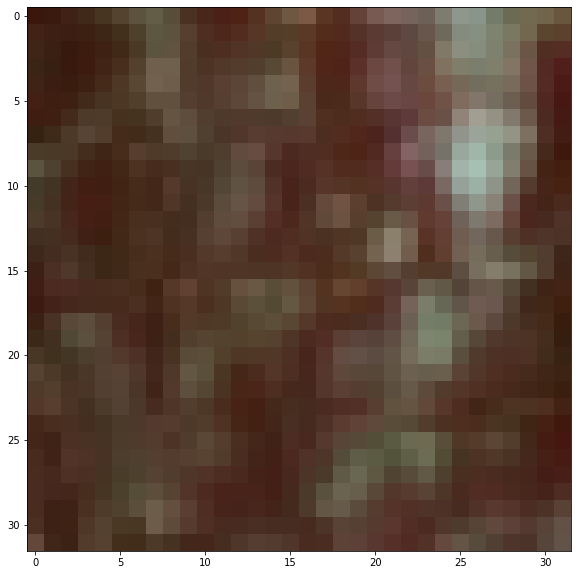

In [42]:
plt.figure(figsize=(10, 10))
plt.imshow(dados[labels=='marble'][5])
plt.show()

In [43]:
lb={'andesite':[1, 0, 0, 0, 0, 0] ,'gneiss':[0, 1, 0, 0, 0, 0] ,'marble':[0, 0, 1, 0, 0, 0], 'quartzite':[0, 0, 0, 1, 0, 0], 'rhyolite':[0, 0, 0, 0, 1, 0], 'schist':[0, 0, 0, 0, 0, 1]}
len(labels)

labels1 = [lb[label] for label in labels]
labels1 = np.array(labels1)
print(labels1)



[[0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 ...
 [0 0 1 0 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]]


In [44]:
# executa codificação one-hot nas tags

#lb = LabelBinarizer()
#labels2 = lb.fit_transform(labels)
#labels2 = to_categorical(labels2)
#labels2
#type(labels2)

# **Criando o Dataframe em dados de treino, validação e teste**

In [45]:
X_train, X_test, y_train, y_test  = train_test_split(dados, labels1, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train,test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [46]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(17998, 32, 32, 3)
(17998, 6)
(6000, 32, 32, 3)
(6000, 6)
(6000, 32, 32, 3)
(6000, 6)


## Normalização  

In [47]:
#X_train = X_train.reshape(X_train.shape[0], 28, 28, 3).astype('float32')
#X_val = X_val.reshape(X_val.shape[0], 28, 28, 3).astype('float32')
#X_test = X_test.reshape(X_test.shape[0], 28, 28, 3).astype('float32')

X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

#  Conhecendo os dados de imagem

In [48]:
from numpy import asarray
image = Image.open("geological_similarity/gneiss/0QTQE.jpg")
# Método asarray para realizar a conversão:
pixels= asarray(image)
# Verificando a faixa de valores entre 0 e 255:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

#Converte os valores inteiros em float para realizar a operação:
pixels = pixels.astype('float32')
# Normaliza a faixa de valores:
pixels /= pixels.max()
# Verificando a faixa de valores normalizada:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 32.000, Max: 251.000
Data Type: float32
Min: 0.127, Max: 1.000


# **Limpeza de dados**
1 - Analisando os dados ausentes
2 - Descartando os dados ausentes
3 - Imputando dados
4 - Acrescentando colunas informativas

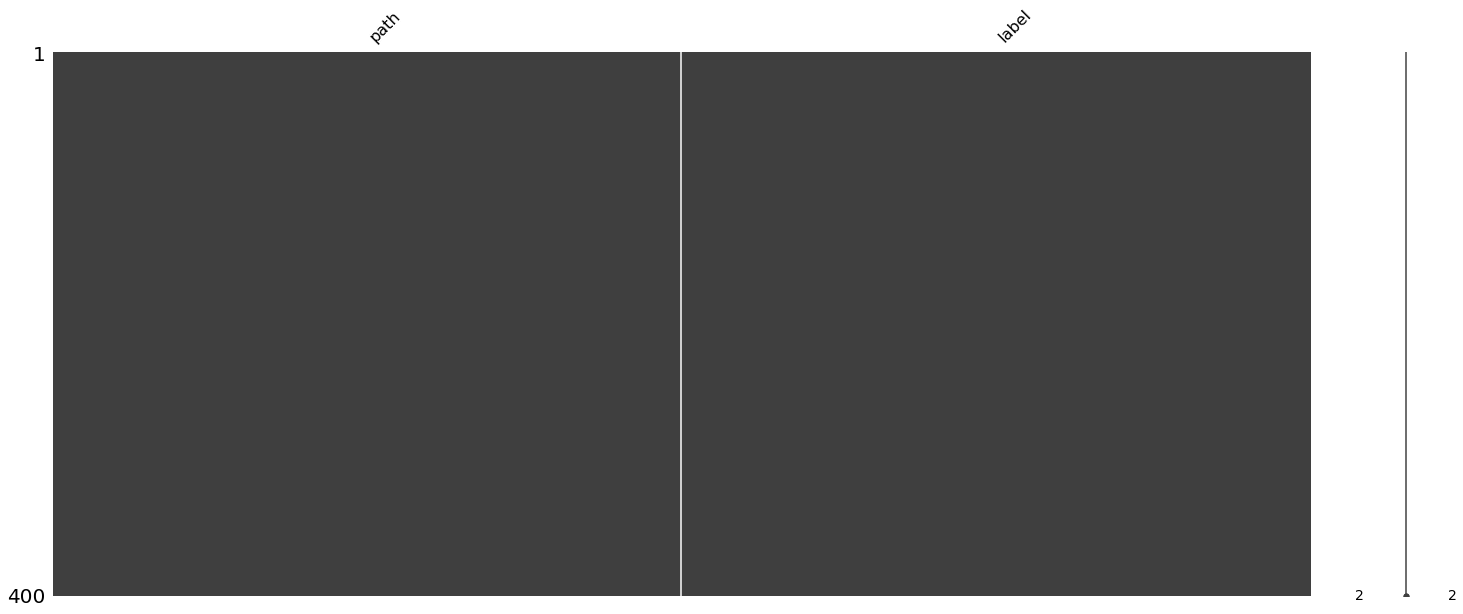

In [49]:
### 1 - Analisando os dados ausentes ###

import missingno as msno
ax = msno.matrix(data_df.sample(400))

In [50]:
#! pip install pandas-profiling==2.8.0
#from pandas_profiling import ProfileReport
#ProfileReport (data_df)

# ***Criação dos Parâmetros***

In [51]:
INIT_LR = 1e-3
EPOCHS = 100
BS=24

# **Explorando os dados**


# **Type: Data Augumentation**

## ** Esta função irá plotar as imagens num grid de 1 a 5 colunas **

In [52]:
IMG_SHAPE = 32

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [53]:
# Dados de Treino e Validação

datagen = ImageDataGenerator(rescale=1./255,
                            #featurewise_center =False ,
                            # samplewise_center =False ,
                            # featurewise_std_normalization =False ,
                            # samplewise_std_normalization =False ,
                            # zca_whitening =False ,
                            # zca_epsilon =1e -6 ,
                            # channel_shift_range =0. ,
                            # fill_mode = ’ nearest ’ ,
                            # cval =0. ,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split=0.2)

datagen_val = ImageDataGenerator (rescale=1./255, 
                                 validation_split=0.2)

In [54]:
train_generator = datagen.flow_from_dataframe (data_df,
    batch_size=BS,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='training')

validation_generator = datagen_val.flow_from_dataframe (data_df,
    batch_size=BS,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='validation')

Found 23999 validated image filenames belonging to 6 classes.
Found 5999 validated image filenames belonging to 6 classes.


In [55]:
# Dados de Teste

datagen_test = ImageDataGenerator (rescale=1./255, 
                                  rotation_range = 40)

test_generator = datagen_test.flow_from_dataframe(data_df,
                                                   batch_size=1,
                                                   x_col='path',
                                                   y_col='label',
                                                   shuffle=False,
                                                   target_size=(IMG_SHAPE,IMG_SHAPE),
                                                   class_mode='categorical')
                                                   #subset='validation')

Found 29998 validated image filenames belonging to 6 classes.


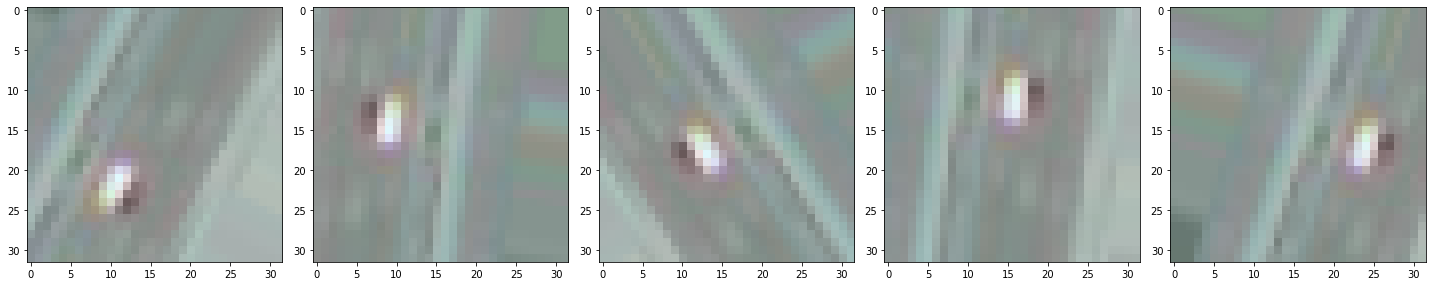

In [56]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [57]:
class_dict=test_generator.class_indices
labels= test_generator.labels
file_names= test_generator.filenames 

train_generator.class_indices.keys()

dict_keys(['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist'])

In [58]:
#X_test, y_test = next(test_generator)

# **Criar o modelo**

In [59]:
num_classes = 6

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
   
])

# **Compilando o Modelo**

In [60]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])
model.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 16)         

In [61]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        #save_weights_only=False,
        #mode='auto',
        #period=1,
    ),

]

# **Avaliar o modelo**

In [62]:
history = model.fit(X_train,y_train,
                               epochs=EPOCHS,
                               verbose=1,
                               callbacks=callbacks_list,
                               steps_per_epoch = len(X_train)//BS, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               workers=4,
                               use_multiprocessing=True,
                               validation_steps = len(X_val)//BS,
                               validation_data= (X_val,y_val))

Epoch 1/100
749/749 [==============================] - 48s 63ms/step - loss: 0.9003 - accuracy: 0.6584 - val_loss: 0.3740 - val_accuracy: 0.8900

Epoch 00001: val_accuracy improved from -inf to 0.89000, saving model to best_model.h5
Epoch 2/100
749/749 [==============================] - 47s 62ms/step - loss: 0.4127 - accuracy: 0.8540 - val_loss: 0.2803 - val_accuracy: 0.8877

Epoch 00002: val_accuracy did not improve from 0.89000
Epoch 3/100
749/749 [==============================] - 48s 64ms/step - loss: 0.3074 - accuracy: 0.8980 - val_loss: 0.1703 - val_accuracy: 0.9430

Epoch 00003: val_accuracy improved from 0.89000 to 0.94300, saving model to best_model.h5
Epoch 4/100
749/749 [==============================] - 48s 64ms/step - loss: 0.2610 - accuracy: 0.9122 - val_loss: 0.1815 - val_accuracy: 0.9323

Epoch 00004: val_accuracy did not improve from 0.94300
Epoch 5/100
749/749 [==============================] - 50s 66ms/step - loss: 0.2331 - accuracy: 0.9248 - val_loss: 0.2011 - val_a

**Deixe-nos representar graficamente a Precisão do treinamento versus perda para obter uma melhor compreensão do treinamento do modelo.**

Text(0.5, 1.0, 'Train - Accuracy')

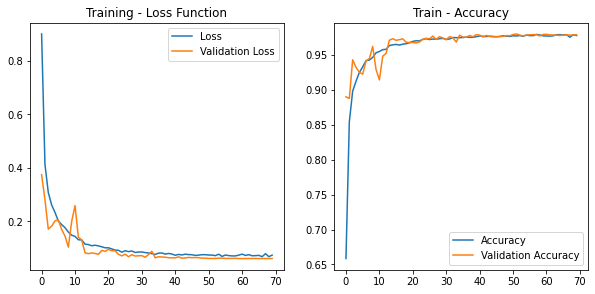

In [63]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')


# **Vamos traçar a precisão do treinamento e da validação, bem como a perda.** 

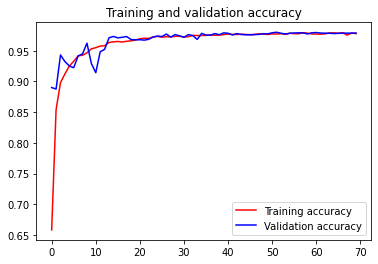

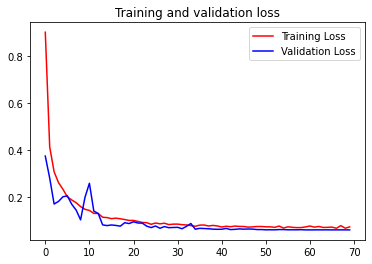

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [65]:
#history2= model.history.history
#px.line(history2,title = "Metrics Plot")

# **Otimizar o modelo**

In [66]:
# Aguardando codigo

# **Avaliar acurácia  do Modelo**

In [67]:
model = tf.keras.models.load_model("best_model.h5")

test_loss, test_acc= model.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_acc))

188/188 [==============================] - 3s 16ms/step - loss: 0.0656 - accuracy: 0.9783
validation_accuracy: 0.9783333539962769


# **Listando as redes realmente disponíveis em seu Keras**

In [68]:
import tensorflow.keras.applications as app
print(dir(app))

['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'densenet', 'efficientnet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']


# **O Modelo pre treinado VGG16**
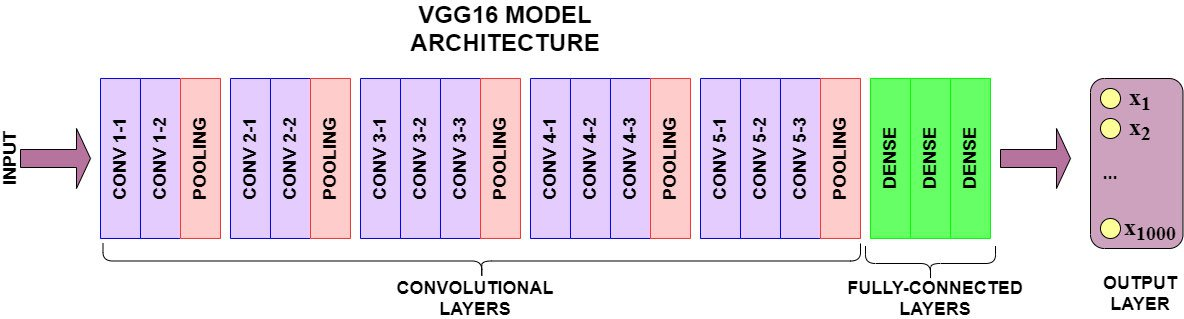

In [69]:
# Inicializar a CNN
classifier = VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3))

58900480/58889256 [==============================] - 0s 0us/step


In [70]:
# Marcar as camadas como não treináveis
#for layer in classifier.layers:
   # layer.trainable = False

for layer in classifier.layers[:-2]:
  layer.trainable = False
  print(layer)

# Criar o novo modelo
inputs = tf.keras.Input(shape=(32, 32, 3))
#x = datagen (inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1 , offset=-1)
x = scale_layer(inputs)

# Adicionar novas camadas para classificação

x = classifier(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Regularize with dropout
output = Dense(6, activation='softmax')(x)

#flat1 = tf.keras.layers.Flatten()(classifier.layers[-1].output)
#flat1 = Dense(1024, activation='relu', kernel_initializer='he_uniform')(flat1)
#flat1 = tf.keras.layers.Dropout(0.5)(flat1)
#output = Dense(6, activation='softmax')(flat1)

# Definir o modelo
modelvgg16 = Model(inputs=inputs, outputs=output)

modelvgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0     

In [71]:
modelvgg16.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])  

callbacksvgg16 = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='feature_extraction.vgg16',
        save_best_only=True,
        monitor="val_accuracy",
    ),

]

In [72]:
historyvgg16 = modelvgg16.fit(X_train,y_train,
                    epochs=EPOCHS,
                    verbose=1,
                    steps_per_epoch = len(X_train)//BS,
                    callbacks=callbacksvgg16,
                    validation_data=(X_val,y_val),
                    validation_steps = len(X_val) //BS)

Epoch 1/100
749/749 [==============================] - 291s 387ms/step - loss: 0.4908 - accuracy: 0.8278 - val_loss: 0.2446 - val_accuracy: 0.9105
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 2/100
749/749 [==============================] - 290s 388ms/step - loss: 0.2690 - accuracy: 0.9073 - val_loss: 0.1656 - val_accuracy: 0.9440
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 3/100
749/749 [==============================] - 296s 395ms/step - loss: 0.2164 - accuracy: 0.9274 - val_loss: 0.1507 - val_accuracy: 0.9473
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 4/100
749/749 [==============================] - 295s 394ms/step - loss: 0.1839 - accuracy: 0.9369 - val_loss: 0.1231 - val_accuracy: 0.9575
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 5/100
749/749 [==============================] - 302s 403ms/step - loss: 0.1701 - accuracy: 0.9419 - val_loss: 0.1248 - val_accuracy: 0.95

KeyboardInterrupt: ignored

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = historyvgg16.history['accuracy']
val_acc = historyvgg16.history['val_accuracy']
loss = historyvgg16.history['loss']
val_loss = historyvgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [73]:
modelvgg16 = tf.keras.models.load_model("feature_extraction.vgg16")

test_lossvgg16, test_accvgg16= modelvgg16.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_accvgg16))

188/188 [==============================] - 65s 345ms/step - loss: 0.1118 - accuracy: 0.9595
validation_accuracy: 0.9595000147819519


# **Realizar as predições para as classes com o modelo criado**

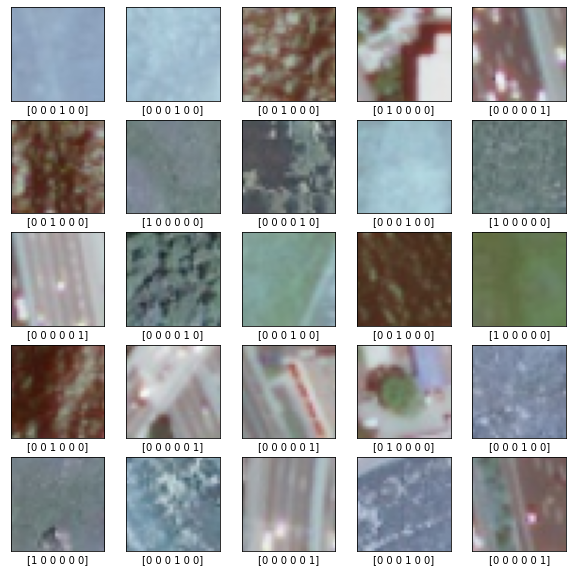

In [74]:
class_names = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']
#class_names = [0,1,2,3,4,5]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()
   

In [75]:
y_pred = model.predict(X_test)
print("Prediction_accuracy: " + str(y_pred))

Prediction_accuracy: [[3.73673975e-05 2.39733875e-01 1.05477864e-06 8.17553955e-05
  5.25078519e-07 7.60145366e-01]
 [8.84348333e-01 1.02144295e-05 2.06257778e-06 1.15084447e-01
  4.38020303e-04 1.16948919e-04]
 [9.01087815e-10 4.83970371e-06 1.07527407e-11 8.89517864e-08
  1.44083584e-12 9.99995112e-01]
 ...
 [1.67192763e-06 4.24478316e-07 2.12886930e-09 9.99966979e-01
  1.87127576e-08 3.08414019e-05]
 [1.87384896e-04 3.37941088e-07 3.47634210e-09 9.99811351e-01
  4.75867310e-08 9.57349471e-07]
 [1.38150469e-07 1.33093818e-06 1.50718854e-10 2.58341133e-05
  6.81351198e-09 9.99972701e-01]]


In [76]:
y_pred[400] # primeira predição posição 400

array([5.0675189e-05, 4.7984317e-10, 1.0784051e-07, 4.7587432e-06,
       9.9994433e-01, 1.0194683e-07], dtype=float32)

In [77]:
print(np.argmax(y_pred[400])) # Nesse caso, a predição está correta -Classe 05

4


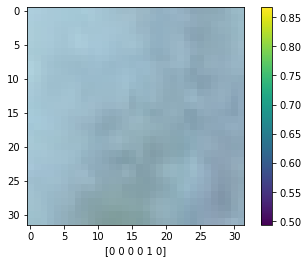

In [78]:
y_test [400] # correta - Classe 05, conforme figura abaixo

plt.figure()
plt.imshow(X_train[400])
plt.xlabel(y_test[400])
plt.colorbar()
plt.grid(False)
plt.show()

In [79]:
y_pred[0] # primeira predição posição 0

array([3.7367397e-05, 2.3973387e-01, 1.0547786e-06, 8.1755396e-05,
       5.2507852e-07, 7.6014537e-01], dtype=float32)

In [80]:
np.argmax(y_pred[0]) # Nesse caso, a predição está correta - Classe 01

5

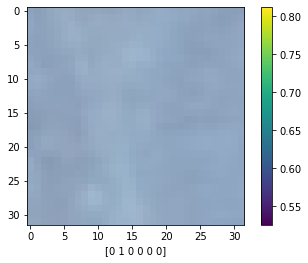

In [81]:
y_test [0] # correta - Classe 01, conforme figura abaixo

plt.figure()
plt.imshow(X_train[0])
plt.xlabel(y_test[0])
plt.colorbar()
plt.grid(False)
plt.show()

# **Matriz de Confusão**

In [82]:
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix

y_pred = model.predict(X_test,batch_size=BS)
y_pred = np.argmax(y_pred, axis=1)

confusion_matrix(y_test.argmax(axis=1),y_pred)

array([[ 937,    1,    0,   31,   12,    0],
       [   0,  965,    0,    0,    0,   20],
       [   0,    1,  987,    0,    0,    0],
       [  29,    1,    0,  951,    1,    2],
       [  10,    0,    0,    0, 1005,    0],
       [   0,   22,    0,    0,    0, 1025]])

# **Matriz de Confusão com mapa de calor**

In [91]:
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model.predict(test_generator)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [94]:
scratch_preds = model.predict(test_generator)
scratch_pred_classes = np.argmax(scratch_preds, axis=1)

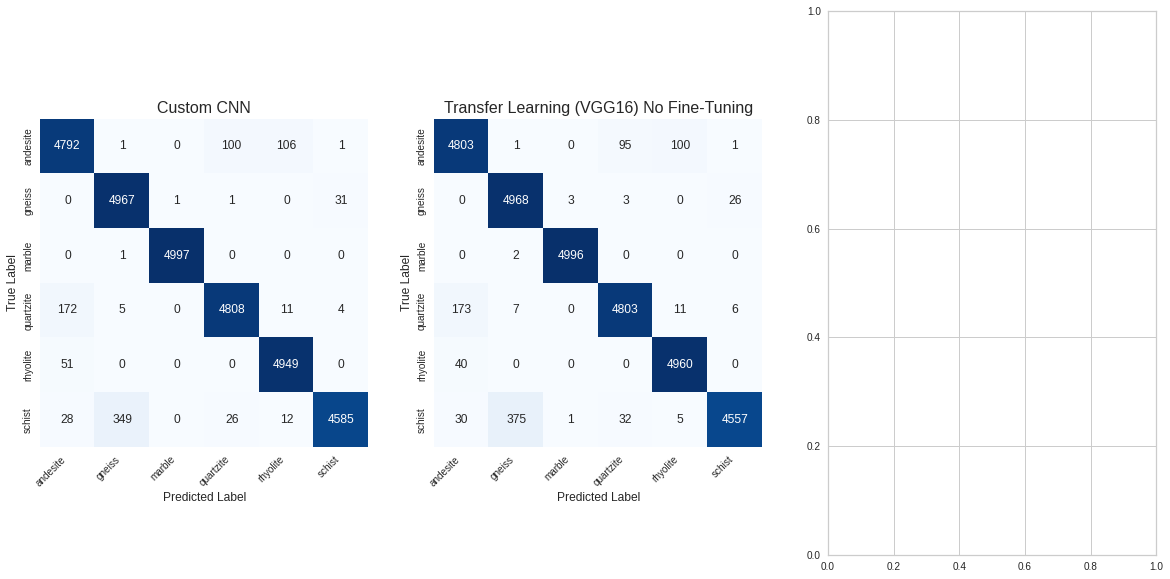

In [96]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names1 = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names1, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names1, 
        yticklabels=class_names1,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plot_heatmap(true_classes, scratch_pred_classes, class_names1, ax1, title="Custom CNN")    
plot_heatmap(true_classes, vgg_pred_classes, class_names1, ax2, title="Transfer Learning (VGG16) No Fine-Tuning")    
#plot_heatmap(true_classes, vgg_pred_classes_ft, class_names1, ax3, title="Transfer Learning (VGG16) with Fine-Tuning") 

# ** Modelo treinado para fazer a predição de uma única imagem.**

In [ ]:
img = X_test [50]
test_labels_single = y_test [50]
print(img.shape)

test_labels_single

# Adiciona a imagem em um batch que possui um só membro.
img = (np.expand_dims(img,0))

print(img.shape)

In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

In [ ]:
predictions_single = np.argmax(predictions_single, axis=1)
predictions_single

In [ ]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title("Prediction Class = ") 
    axes[i].set_title("Original Class =" )
plt.subplots_adjust(wspace=0.5)

# **Comparandos os modelos - Criado VS VGG16**

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [test_acc,test_accvgg16]
model = ['Modelo Criado','Modelo pre treinado VGG16']
#model = ['Modelo Criado','VGG16','InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()